In [17]:

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

import pandas as pd

In [5]:

feature_names = [
    "temperature", "humidity", "wind_speed", "pressure", "precipitation",
    "cloud_cover", "visibility", "dew_point", "solar_radiation", "wind_direction"
]

# créer un jeu de données synthétique
X_array, y = make_classification(
    n_samples=1000,
    n_features=len(feature_names),
    n_informative=6,
    n_redundant=2,
    n_repeated=0,
    n_classes=2,
    weights=[0.6, 0.4],
    class_sep=1.0,
    random_state=42
)

# convertir en DataFrame / Series avec noms de colonnes explicites
X = pd.DataFrame(X_array, columns=feature_names)
y = pd.Series(y, name="rain_today")  # cible binaire : ex. pluie aujourd'hui (0/1)

# aperçu
print("X shape:", X.shape)
print("y shape:", y.shape)
print(X.head())
print(y.value_counts())

X shape: (1000, 10)
y shape: (1000,)
   temperature  humidity  wind_speed  pressure  precipitation  cloud_cover  \
0    -1.030931  1.391626    0.547274  0.928932      -1.738880     1.250002   
1    -2.766254  1.247870   -0.303691  1.083145       0.710836     1.968202   
2    -0.558987  0.299849    1.527071  0.360442      -1.360209     1.100793   
3    -1.350289 -2.046078   -0.614264  0.126459      -0.783923     5.895026   
4    -0.275754 -0.728495    0.027727 -0.660834      -1.928161     3.544945   

   visibility  dew_point  solar_radiation  wind_direction  
0    1.332551   1.578256         2.124722       -0.318434  
1   -1.794192   2.346422         1.700778       -0.001190  
2   -0.755951   1.331933         2.041105       -0.824404  
3   -0.915477  -3.184768        -0.399260       -3.920960  
4    1.446944  -1.111662         0.313766       -2.376528  
rain_today
0    598
1    402
Name: count, dtype: int64


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# vérification rapide
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train class proportions:\n", y_train.value_counts(normalize=True))
print("y_test class proportions:\n", y_test.value_counts(normalize=True))


X_train shape: (700, 10)
X_test shape: (300, 10)
y_train class proportions:
 rain_today
0    0.598571
1    0.401429
Name: proportion, dtype: float64
y_test class proportions:
 rain_today
0    0.596667
1    0.403333
Name: proportion, dtype: float64


In [7]:
# créer une cible "clothes" synthétique à partir des variables météo (seuils calculés sur X_train)
# le quantile 33% et 66% de la température pour définir 3 niveaux : froid, tempéré, chaud
# la médiane de la précipitation pour définir s'il pleut ou non
t_low, t_high = X_train["temperature"].quantile([0.33, 0.66])
precip_median = X_train["precipitation"].quantile(0.5)

def make_clothes_labels(df, t_low, t_high, precip_med):
    labels = []
    for temp, precip in zip(df["temperature"], df["precipitation"]):
        if precip > precip_med:
            labels.append("raincoat")
        elif temp <= t_low:
            labels.append("heavy_jacket")
        elif temp <= t_high:
            labels.append("jacket")
        else:
            labels.append("tshirt")
    return pd.Series(labels, index=df.index, name="clothes")

y_train_clothes = make_clothes_labels(X_train, t_low, t_high, precip_median)
y_test_clothes  = make_clothes_labels(X_test,  t_low, t_high, precip_median)

print("y_train_clothes class distribution:\n", y_train_clothes.value_counts())
print("y_test_clothes class distribution:\n", y_test_clothes.value_counts())

y_train_clothes class distribution:
 clothes
raincoat        350
jacket          127
tshirt          125
heavy_jacket     98
Name: count, dtype: int64
y_test_clothes class distribution:
 clothes
raincoat        147
jacket           58
tshirt           57
heavy_jacket     38
Name: count, dtype: int64


In [11]:

# encoder les étiquettes
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_clothes)
y_test_enc  = le.transform(y_test_clothes)

# entraîner un arbre de décision
clf_model = DecisionTreeClassifier(random_state=42, max_depth=5)
clf_model.fit(X_train, y_train_enc)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",5
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current no

In [12]:

# prédictions et évaluation
y_pred = clf_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test_enc, y_pred))
print("\nClassification report:\n", classification_report(y_test_enc, y_pred, target_names=le.classes_))


Accuracy: 1.0

Classification report:
               precision    recall  f1-score   support

heavy_jacket       1.00      1.00      1.00        38
      jacket       1.00      1.00      1.00        58
    raincoat       1.00      1.00      1.00       147
      tshirt       1.00      1.00      1.00        57

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



In [19]:
# créer quelques journées fictives en utilisant la moyenne pour les autres features
base = X_train.mean()

scenarios = [
    ("cold_dry",   t_low - 1.0,          precip_median - 1.0),
    ("mild_dry",   0.5*(t_low + t_high), precip_median - 0.1),
    ("hot_dry",    t_high + 1.0,         precip_median - 1.0),
    ("rainy_cold", t_low - 0.5,          precip_median + 1.0),
    ("rainy_warm", t_high + 0.5,         precip_median + 1.0),
]

rows = []
names = []
for name, temp_val, precip_val in scenarios:
    r = base.copy()
    r["temperature"] = temp_val
    r["precipitation"] = precip_val
    rows.append(r)
    names.append(name)

df_fict = pd.DataFrame(rows, index=names)[X_train.columns]  # garder l'ordre des colonnes

# prédictions
y_pred_enc = clf_model.predict(df_fict)
y_pred = le.inverse_transform(y_pred_enc)

# probabilités par classe
proba = clf_model.predict_proba(df_fict)
proba_df = pd.DataFrame(proba, index=names, columns=le.classes_)

# résultat résumé
result = df_fict.copy()
result["predicted_clothes"] = y_pred
result = result.join(proba_df)

print(result)

            temperature  humidity  wind_speed  pressure  precipitation  \
cold_dry      -2.482992  0.382296    -0.10292 -0.014974      -1.517744   
mild_dry      -0.999722  0.382296    -0.10292 -0.014974      -0.617744   
hot_dry        0.483548  0.382296    -0.10292 -0.014974      -1.517744   
rainy_cold    -1.982992  0.382296    -0.10292 -0.014974       0.482256   
rainy_warm    -0.016452  0.382296    -0.10292 -0.014974       0.482256   

            cloud_cover  visibility  dew_point  solar_radiation  \
cold_dry       1.045902   -0.013257   0.038398         0.983777   
mild_dry       1.045902   -0.013257   0.038398         0.983777   
hot_dry        1.045902   -0.013257   0.038398         0.983777   
rainy_cold     1.045902   -0.013257   0.038398         0.983777   
rainy_warm     1.045902   -0.013257   0.038398         0.983777   

            wind_direction predicted_clothes  heavy_jacket  jacket  raincoat  \
cold_dry         -0.228876      heavy_jacket           1.0     0.0      

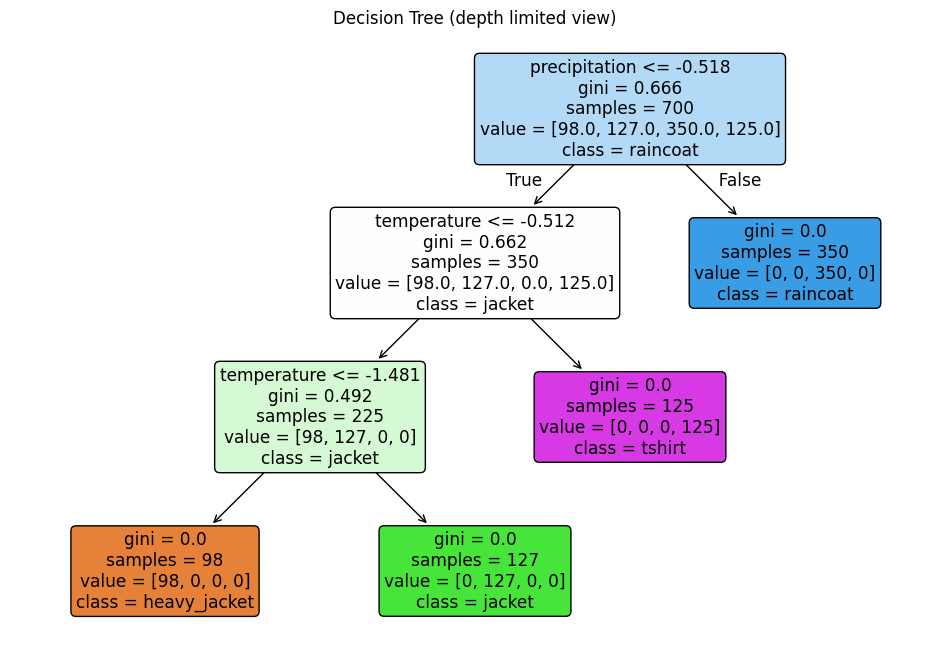

In [10]:
plt.figure(figsize=(12,8))
plot_tree(clf_model, feature_names=X_train.columns, class_names=le.classes_, filled=True, rounded=True, max_depth=3)
plt.title("Decision Tree (depth limited view)")
plt.show()

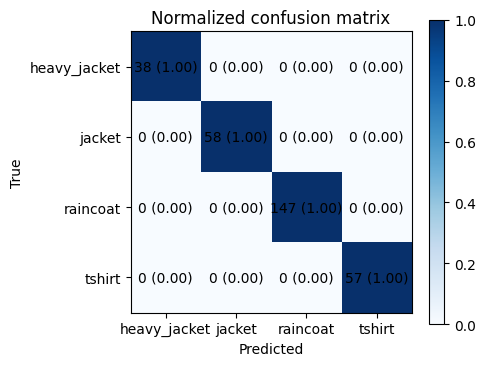

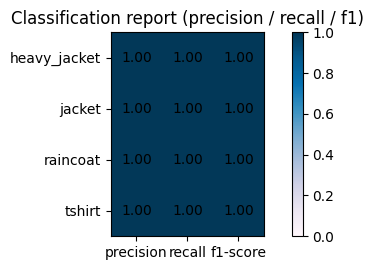

In [23]:
# matrice de confusion (normalisée) + annotations
y_test_pred = clf_model.predict(X_test)  # Predict on the test dataset
cm = confusion_matrix(y_test_enc, y_test_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1)[:, None]

fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm_norm, cmap="Blues", vmin=0, vmax=1)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm[i,j]} ({cm_norm[i,j]:.2f})",
                ha="center", va="center", color="black")
ax.set_xticks(range(len(le.classes_)))
ax.set_xticklabels(le.classes_)
ax.set_yticks(range(len(le.classes_)))
ax.set_yticklabels(le.classes_)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Normalized confusion matrix")
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

cr = classification_report(y_test_enc, y_test_pred, target_names=le.classes_, output_dict=True)
cr_df = pd.DataFrame(cr).transpose()
metrics_df = cr_df.loc[le.classes_, ["precision", "recall", "f1-score"]]

fig, ax = plt.subplots(figsize=(6,2.8))
im2 = ax.imshow(metrics_df.values, cmap="PuBu", vmin=0, vmax=1)
for i in range(metrics_df.shape[0]):
    for j in range(metrics_df.shape[1]):
        ax.text(j, i, f"{metrics_df.values[i,j]:.2f}", ha="center", va="center", color="black")
ax.set_xticks(range(metrics_df.shape[1]))
ax.set_xticklabels(metrics_df.columns)
ax.set_yticks(range(metrics_df.shape[0]))
ax.set_yticklabels(metrics_df.index)
ax.set_title("Classification report (precision / recall / f1)")
fig.colorbar(im2, ax=ax)
plt.tight_layout()
plt.show()

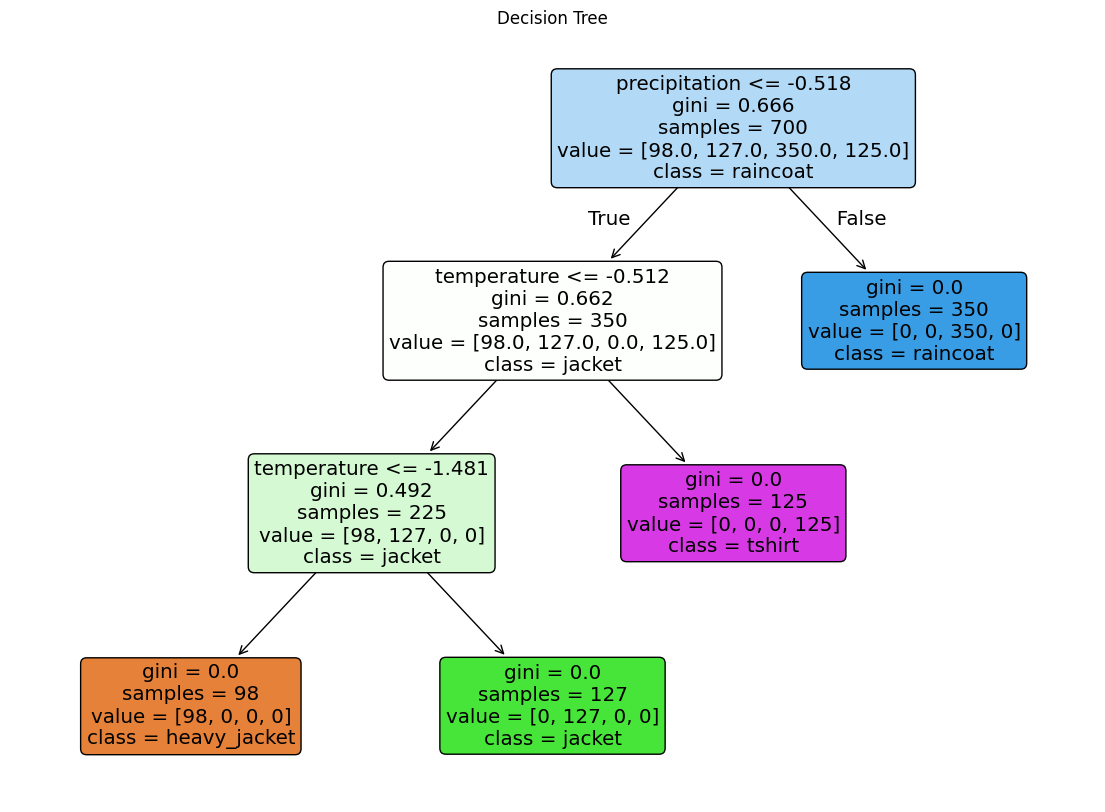

cold_dry: leaf 3 | pred=heavy_jacket | probs={'heavy_jacket': 1.0, 'jacket': 0.0, 'raincoat': 0.0, 'tshirt': 0.0}
  path: precipitation <= -0.518 AND temperature <= -0.512 AND temperature <= -1.481

mild_dry: leaf 4 | pred=jacket | probs={'heavy_jacket': 0.0, 'jacket': 1.0, 'raincoat': 0.0, 'tshirt': 0.0}
  path: precipitation <= -0.518 AND temperature <= -0.512 AND temperature > -1.481

hot_dry: leaf 5 | pred=tshirt | probs={'heavy_jacket': 0.0, 'jacket': 0.0, 'raincoat': 0.0, 'tshirt': 1.0}
  path: precipitation <= -0.518 AND temperature > -0.512

rainy_cold: leaf 6 | pred=raincoat | probs={'heavy_jacket': 0.0, 'jacket': 0.0, 'raincoat': 1.0, 'tshirt': 0.0}
  path: precipitation > -0.518

rainy_warm: leaf 6 | pred=raincoat | probs={'heavy_jacket': 0.0, 'jacket': 0.0, 'raincoat': 1.0, 'tshirt': 0.0}
  path: precipitation > -0.518



In [24]:
# afficher l'arbre
plt.figure(figsize=(14,10))
plot_tree(clf_model, feature_names=X_train.columns, class_names=le.classes_, filled=True, rounded=True)
plt.title("Decision Tree")
plt.axis("off")
plt.show()

# afficher pour chaque journée fictive la feuille et le chemin de décision
tree = clf_model.tree_
children_left = tree.children_left
children_right = tree.children_right
feature = tree.feature
threshold = tree.threshold
n_nodes = tree.node_count

# construire un dictionnaire parent -> (parent_node, side)
parent = {}
for node in range(n_nodes):
    left = children_left[node]
    right = children_right[node]
    if left != -1:
        parent[left] = (node, "left")
    if right != -1:
        parent[right] = (node, "right")

def path_rules(node_id):
    rules = []
    node = node_id
    while node != 0:
        p, side = parent[node]
        feat_idx = feature[p]
        thr = threshold[p]
        feat_name = X_train.columns[feat_idx]
        if side == "left":
            rules.append(f"{feat_name} <= {thr:.3f}")
        else:
            rules.append(f"{feat_name} > {thr:.3f}")
        node = p
    return " AND ".join(reversed(rules)) or "root"

leaf_ids = clf_model.apply(df_fict)
for name, leaf in zip(df_fict.index, leaf_ids):
    probs = proba_df.loc[name].to_dict()
    pred = result.loc[name, "predicted_clothes"]
    print(f"{name}: leaf {leaf} | pred={pred} | probs={probs}")
    print("  path:", path_rules(leaf))
    print()